В данном проекте я делаю нейронную сеть LSTM для предсказания цены закрытия акции Амазона на следующий день, используя данные о минимальной, максимальной ценах, ценах закрытия и открытия. Изначально я хотел использовать еще новости, для улучшения точности прогноза, например используя трансформер(чтобы получить вектор новости), но злые капиталисты помешали мне, так как API, которые дают информацию о новостях стоят денег, поэтому я отложил использование новостей на будущее улучшение проекта. LSTM проходит по 7 последним дня и должна предсказывать завтрашнюю цену. Данные по акциям для обучения я взял с сайта Yahoo finance, а для предсказания я беру данные из их неофициального API. 

yfinance is not affiliated, endorsed, or vetted by Yahoo, Inc. It's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes.

In [67]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Загрузка данных
data = pd.read_csv('AMZN.csv')


In [55]:
import numpy as np

Подготовка данных

In [68]:
del data['Volume']

In [69]:
del data['Date']

In [70]:
del data['Adj Close']

In [71]:
data

,Open,High,Low,Close
0,58.599998,59.500000,58.525501,59.450500
1,59.415001,60.274502,59.415001,60.209999
2,60.250000,60.793499,60.233002,60.479500
3,60.875500,61.457001,60.500000,61.457001
4,61.799999,62.653999,61.601501,62.343498
...,...,...,...,...
1364,123.360001,125.800003,123.029999,125.300003
1365,125.070000,127.400002,125.000000,126.610001
1366,127.010002,127.370003,120.629997,121.230003
1367,123.010002,125.629997,122.260002,124.250000


Тестовую выборку делаем равной 10%. Ни в коем случае не перемешиваем, так как иначе данные из будущего теста могут попасть в трейн, а так же соседние дни связаны, и лстм бежит по рядом стоящим дням.

In [59]:
train_data = data[:int(len(data)*0.9)]
test_data = data[int(len(data)*0.9):]

Нормализуем данные для стабильного обучения с помощью MinMaxScaler. Не забываем, что обучать надо только на трейне

In [60]:
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

Вот сама LSTM, так же используем линейной слой, чтобы трансформировать скрытый слой в предсказание. Обучение проходит на видеокарте

In [61]:
import torch
import torch.nn as nn

# Определение модели
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(num_layers,1,self.hidden_layer_size),
                            torch.zeros(num_layers,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


# Перенос модели на GPU, если доступна
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Функция которая трансформирует данные в последовательности фиксированной длин seq_length, таргетом является closed price в следующем периоде

In [62]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(seq_length, len(data)-1):
        x = data[i-seq_length:i]
        y = data[i+1, 3]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)



Теперь трансформация самих данных, используем последовательности длины 7, то есть неделя

In [118]:
seq_length = 7
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


Сам процесс обучения, оптимайзер используем Adam, так как это классика. Эпох будет 20. Так же рисуем график обновляющийся в реальном времени, показывающий текущий лосс в эпохе. 

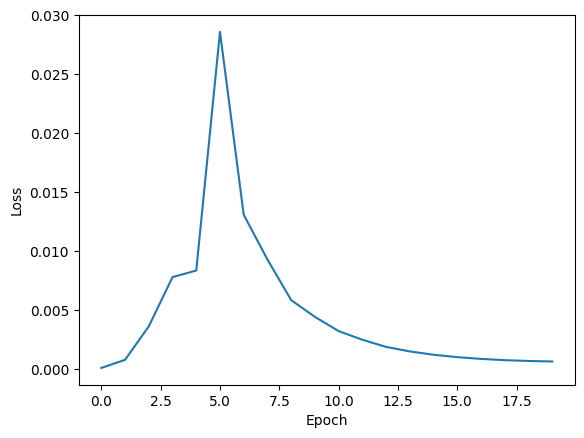

epoch:  19 loss: 0.0006390241


In [114]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

model = LSTM(input_size=4, hidden_layer_size=100, output_size=1, num_layers=2)
model = model.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20

# Создание списка для сохранения потерь
losses = []

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size).to(device),
                        torch.zeros(2, 1, model.hidden_layer_size).to(device))

        seq = seq.to(device)
        labels = torch.Tensor(np.array([labels])).to(device)
        
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    # Сохранение потерь
    losses.append(single_loss.item())
    
    # Очистка текущего вывода и отображение графика
    clear_output(wait=True)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


Здесь мы делаем предсказания на тесте и рисуем график для сравнения с реальными ценами, так же не забываем сделать inverse_transorm так как модель работала с нормированными данным и предсказния следовательно делала тоже нормированные.Так же обучаем новый scaler, так как старый нормирует данные с 4 фичами, а нам нужно отдельно инверсить только одну фичу

In [119]:
model.eval()

test_predictions = []
with torch.no_grad():
    for seq in X_test:
        seq = seq.to(device)
        test_predictions.append(model(seq).item())

# Обучение нового scaler только на тренировочных 'close' данных
scaler_close = MinMaxScaler()
scaler_close.fit(data.iloc[:len(X_train)][['Close']])

# Используем новый scaler для денормализации
test_predictions = scaler_close.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Денормализация истинных значений
y_test = scaler_close.inverse_transform(y_test.reshape(-1, 1))


# Создание DataFrame для удобства
df = pd.DataFrame({
    "Real": y_test.flatten(),
    "Predicted": np.array(test_predictions).flatten(),
})
df['Error'] = df['Real'] - df['Predicted'] #в дальнейшем нам понадобится, чтобы добавить возможность наведения на график

Сам график, используем plotly.graph_objects, чтобы график был интерактивным и при наведенеии на него показывалось, на сколько ошиблась модель вверх или вниз

In [120]:
import plotly.graph_objects as go

days = 100  # Тут можем задать сколько дней мы хотим видеть на графике

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(days), y=df['Real'][:days],
                mode='lines',
                name='Real'))

fig.add_trace(go.Scatter(x=np.arange(days), y=df['Predicted'][:days],
                mode='lines',
                name='Predicted',
                text=['Error: {}'.format(i) for i in df['Error'][:days]],
                hoverinfo='text+y'))

fig.update_traces(textposition='top center')

fig.update_layout(
    title="Comparison of Real and Predicted in Amazon Stock Price",
    xaxis_title="Days",
    yaxis_title="Price",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"
    )
)

fig.show()


На графике видно, что модель работает, но все же ошибается много где, так как из-за стохастической природы данных, сложно делать предсказания зная только цены и было бы куда лучше использовать вместе с ними и новости, но опять же злые капиталисты помешали мне сделать это

In [46]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.1 MB/s eta 0:00:00


Теперь получаем данные из yfinance, забираем данные за последний месяц и берем оттуда последние 7 дней, иначе, если бы мы брали данные просто за последнюю неделю нам могло быть возвращаться меньше 7 дней, так как торги ведутся не ежедневно. И делаем предсказание по последнем 7 дням

In [113]:
import yfinance as yf

# Скачивание данных
data = yf.download('AMZN', period='1mo')

# Обработка данных
data = data[['Open', 'High', 'Low', 'Close']]


data = data.dropna()

# Нормализация данных
data_normalized = scaler.transform(data)

# Использование последних 7 дней данных
last_sequence = data_normalized[-7:]

# Преобразование в torch tensor и добавление измерения для партии
last_sequence = torch.tensor(last_sequence).float().to(device)

# Перевод модели в режим предсказания
model.eval()

# Получение предсказаний модели
with torch.no_grad():
    prediction = model(last_sequence.view(1, 7, -1)[0]).cpu().item()

# Возвращение к оригинальному масштабу
prediction = scaler_close.inverse_transform([[prediction]])

print("Предсказание:", prediction[0][0])


[*********************100%***********************]  1 of 1 completed
Предсказание: 117.25111901875925


В заключении нужно сказать, что ни в коем случае нельзя использовать эту модель для реальных торгов, так как модель все же достаточно сильно ошибается, но в дальнейшем, когда я интегрирую обработку новостей, я думаю, что смогу получить хорошие результаты.
